In [1]:
# Import Libraries
from common.Libraries import *
# Global Config
from common.GlobalConfig import *
# Utils
from common.Utils import *
# Model
from models.BiLSTM_CNN import bilstm_cnn
from models.EarlyStopping import EarlyStopping
# Create folder if not exist
if not os.path.exists('./best_model'):
    os.makedirs('best_model')
# To show wider screen for output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

device = torch.device("cuda")
max_bilstm_cnn_acc = 0.6103
max_random_acc = 0.6103
max_bay_acc = 0.6007

# 1. Helper Function

In [2]:
def train_bilstm_cnn(hidden_size, dropout_rate, learning_rate, l2_reg, num_filters, pool_size, num_mlp_layers, num_lstm_layers, num_cnn_layers, stride=1, kernel_index=0, sigmoid=0, num_of_epochs=5, verbose=False, plot=False, verbose_itr=False, early_stop=True, method='bay'):
    # Build Model
    kernel_size = kernel_sizes_map[int(kernel_index)-1]
    if sigmoid > 0.5:
        sigmoid = True
    else:
        sigmoid = False
#     print(hidden_size, dropout_rate, learning_rate, l2_reg, num_filters, pool_size, num_mlp_layers, num_cnn_layers, kernel_index)
    if not check_valid_cnn_output_size(init_size=max_length, n_layers=int(num_cnn_layers), kernel_sizes=kernel_size, pool_size=int(pool_size), stride=int(stride)):
        return 0
    model = bilstm_cnn(input_length=max_length, vocab_size=vocab_size, hidden_size=int(hidden_size), kernel_sizes=kernel_size,
                     dropout_rate=dropout_rate, num_filters=int(num_filters), num_mlp_layers=int(num_mlp_layers), output_size=output_size,
                     num_cnn_layers=int(num_cnn_layers), num_lstm_layers=int(num_lstm_layers), pool_size=int(pool_size), stride=int(stride), sigmoid=sigmoid)
    model.to(device)
    # Early Stop Instance
    early_stopping = EarlyStopping(patience=4)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    criterion = get_loss_function('BCE')
    model.to(device)
    total_train_acc=[]
    total_valid_acc=[]
    global max_bilstm_cnn_acc
    global max_random_acc
    global max_bay_acc
    max_val_acc = 0
    for e in range(int(num_of_epochs)):    
        if verbose_itr:
            print('Epoch', e+1, flush=True)
        model.train()
        train_acc = 0
        train_count = 0
        train_loss = 0
        train_acc_list = []
        with tqdm.tqdm(train_loader, disable=verbose==False) as t:
            for x, y in t:
                x_ = x.to(device)
                y_ = y.to(device)
                optimizer.zero_grad()
                logits = model(x_)
                loss, cor_count = criterion(logits, y_)
                loss.backward()
                train_acc += cor_count
                train_count += y.size(0)
                train_loss += loss.item() 
                optimizer.step()
                t.set_postfix({'Train loss': train_loss/train_count, 'Train acc': train_acc/train_count})
            total_train_acc.append(train_acc/train_count)
        model.eval()
        valid_acc = 0
        valid_count = 0
        valid_loss = 0
        with tqdm.tqdm(test_loader, disable=verbose==False) as t:
            for x, y in t:
                x_ = x.to(device)
                y_ = y.to(device)
                logits = model(x_)
                loss, cor_count = criterion(logits, y_)
                valid_acc += cor_count
                valid_count += y.size(0)
                valid_loss += loss.item()
                t.set_postfix({'Valid loss': valid_loss/valid_count, 'Valid acc': valid_acc/valid_count})
            total_valid_acc.append(valid_acc/valid_count)
        max_val_acc = max(max_val_acc, valid_acc/valid_count)
        
        if method == 'random':
            if max_val_acc > max_random_acc:
                save_model(model, f'best_bilstm_cnn_model_random_{raw_data_size}')
                max_random_acc = max_val_acc
        else:
            if max_val_acc > max_bay_acc:
                save_model(model, f'best_bilstm_cnn_model_bay_{raw_data_size}')
                max_bay_acc = max_val_acc
        
        
        if max_val_acc > max_bilstm_cnn_acc:
            save_model(model, f'best_bilstm_cnn_model_{raw_data_size}')
            max_bilstm_cnn_acc = max_val_acc
        # Check early stop, use average loss
        if early_stop:
            early_stopping(valid_loss/valid_count)
            if early_stopping.early_stop:
                print("Early stopping", flush=True)
                break
    if plot:
        t = plt.plot(range(1, epochs + 1), total_train_acc, c='blue')[0]
        v = plt.plot(range(1, epochs + 1), total_valid_acc, c='green')[0]
        plt.legend([t, v], ['Train accuracy', 'Validation accuracy'])
        plt.xlabel('Epochs')
        plt.ylim(0.4, 0.8)
        plt.xticks(range(1, epochs + 1))
        plt.show()
    return max_val_acc
def get_trained_model(hidden_size, dropout_rate, learning_rate, l2_reg, num_filters, pool_size, num_mlp_layers, num_lstm_layers, num_cnn_layers, stride=1, kernel_index=0, sigmoid=0, num_of_epochs=5):
    # Build Model
    kernel_size = kernel_sizes_map[int(kernel_index)-1]
    model = bilstm_cnn(input_length=max_length, vocab_size=vocab_size, hidden_size=int(hidden_size), kernel_sizes=kernel_size,
                     dropout_rate=dropout_rate, num_filters=int(num_filters), num_mlp_layers=int(num_mlp_layers), output_size=output_size,
                     num_cnn_layers=int(num_cnn_layers), num_lstm_layers=int(num_lstm_layers), pool_size=int(pool_size), stride=int(stride), sigmoid=sigmoid)
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    criterion = get_loss_function('BCE')
    model.to(device)
    max_val_acc = 0
    for e in range(int(num_of_epochs)):
        model.train()
        with tqdm.tqdm(train_loader, disable=True) as t:
            for x, y in t:
                x_ = x.to(device)
                y_ = y.to(device)
                optimizer.zero_grad()
                logits = model(x_)
                loss, _ = criterion(logits, y_)
                loss.backward()
                optimizer.step()
    return model

# 2. Load Data

In [3]:
train_X = np.load(f'{preprocessed_folder_path}/train_X.npy', allow_pickle=True)
train_Y = np.load(f'{preprocessed_folder_path}/train_Y.npy', allow_pickle=True)
test_X = np.load(f'{preprocessed_folder_path}/test_X.npy', allow_pickle=True)
test_Y = np.load(f'{preprocessed_folder_path}/test_Y.npy', allow_pickle=True)
output_size = train_Y.shape[1]
tag_to_index = pd.read_csv(f'{preprocessed_folder_path}/tag_to_index.csv', index_col='tag')
index_to_tag = pd.read_csv(f'{preprocessed_folder_path}/index_to_tag.csv')
cat_to_index = pd.read_csv(f'{preprocessed_folder_path}/cat_to_index.csv', index_col='cat')
index_to_cat = pd.read_csv(f'{preprocessed_folder_path}/index_to_cat.csv')
tag_to_cat = pd.read_csv(f'{preprocessed_folder_path}/tag_to_cat.csv', index_col='tag')

print(f"Train set shape: {train_X.shape}")
print(f"Test set shape: {test_X.shape}")

Train set shape: (10800, 250, 300)
Test set shape: (2700, 250, 300)


In [4]:
train_loader = DataLoader(MyDataset(train_X, train_Y), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MyDataset(test_X, test_Y), batch_size=batch_size)

# 3. Hyperparameter Tuning

## 3.1 Random Search

In [5]:
random_param_grid = {
    'hidden_size': [i for i in range(param_grid['hidden_size'][0], param_grid['hidden_size'][1]+1)],
    'dropout_rate': [i for i in np.arange(param_grid['dropout_rate'][0], param_grid['dropout_rate'][1]+0.1, 0.1)], 
    'learning_rate': [i for i in np.arange(param_grid['learning_rate'][0], param_grid['learning_rate'][1]+0.001, 0.001)], 
    'l2_reg': [i for i in np.arange(param_grid['l2_reg'][0], param_grid['l2_reg'][1]+0.0001, 0.0001)],
    'num_filters': [i for i in range(param_grid['num_filters'][0], param_grid['num_filters'][1]+1)],
    'pool_size': [i for i in range (param_grid['pool_size'][0], param_grid['pool_size'][1]+1)],
    'num_mlp_layers': [i for i in range(param_grid['num_mlp_layers'][0], param_grid['num_mlp_layers'][1]+1)],
    'num_cnn_layers': [i for i in range(param_grid['num_cnn_layers'][0], param_grid['num_cnn_layers'][1]+1)],
    'num_lstm_layers': [i for i in range(param_grid['num_lstm_layers'][0], param_grid['num_lstm_layers'][1]+1)],
    'kernel_index': [i for i in range(param_grid['kernel_index'][0], param_grid['kernel_index'][1]+1)],
    'num_of_epochs': [i for i in range(param_grid['num_of_epochs'][0], param_grid['num_of_epochs'][1]+1)],
    'sigmoid': [i for i in range(param_grid['sigmoid'][0], param_grid['sigmoid'][1]+1)]
}
def random_search(n=10):
    best_accuracy = 0 
    best_params = {}
    tried_combinations = set()
    for i in range(n):
        print(f"Random Searching...{i+1}/{n}", flush=True)
        # Randomly get a combination
        train_param = {}
        while str(train_param) == '{}' or str(train_param) in tried_combinations:
            for param in random_param_grid:
                train_param[param] = random.choice(param_grid[param])
        train_accuracy = train_bilstm_cnn(**train_param, verbose=100, method='random')
        if train_accuracy > best_accuracy:
            best_accuracy = train_accuracy
            best_params = train_param
        tried_combinations.add(str(train_param))
    return best_params

In [6]:
random_time_start = time.time()
best_random_params = random_search(250)
random_time_end = time.time()
del random_param_grid
random_training_time = (random_time_end - random_time_start)/60

Random Searching...1/250


  1%|          | 7/675 [00:00<00:10, 62.86it/s, Train loss=0.0433, Train acc=0.0156]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 63.61it/s, Train loss=0.0433, Train acc=0.0208]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 64.21it/s, Train loss=0.0433, Train acc=0.0104]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 64.15it/s, Train loss=0.0433, Train acc=0.0156]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 63.24it/s, Train loss=0.0433, Train acc=0.00521]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 147.86it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...2/250



  0%|          | 2/675 [00:00<00:59, 11.39it/s, Train loss=0.045, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:56, 11.94it/s, Train loss=0.0482, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:57, 11.63it/s, Train loss=0.0667, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.29it/s, Valid loss=0.0559, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...3/250
Random Searching...4/250



  0%|          | 2/675 [00:00<00:59, 11.25it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.74it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.41it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...5/250



100%|██████████| 169/169 [00:01<00:00, 147.08it/s, Valid loss=0.0063, Valid acc=0.0567] 

Random Searching...6/250



  1%|          | 7/675 [00:00<00:10, 60.74it/s, Train loss=0.00672, Train acc=0.0417]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 145.08it/s, Valid loss=0.00675, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...7/250
Random Searching...8/250
Random Searching...9/250



  1%|          | 7/675 [00:00<00:10, 61.59it/s, Train loss=0.0433, Train acc=0.0208] 

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 62.17it/s, Train loss=0.0433, Train acc=0.026] 

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 61.55it/s, Train loss=0.0433, Train acc=0.026] 

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 60.97it/s, Train loss=0.0433, Train acc=0.0104]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 62.83it/s, Train loss=0.0433, Train acc=0.0208]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 146.28it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...10/250
Random Searching...11/250



  0%|          | 2/675 [00:00<00:59, 11.40it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.21it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.46it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.19it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.46it/s, Valid loss=0.0434, Valid acc=0.0222]


EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...12/250
Random Searching...13/250


  1%|          | 6/675 [00:00<00:11, 57.32it/s, Train loss=0.00679, Train acc=0.0227]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 142.31it/s, Valid loss=0.00674, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...14/250
Random Searching...15/250



  1%|          | 7/675 [00:00<00:10, 63.52it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 63.84it/s, Train loss=0.0433, Train acc=0.0156]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:01<00:00, 143.90it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 3 out of 4
Random Searching...16/250



  0%|          | 2/675 [00:00<00:58, 11.60it/s, Train loss=0.00684, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.05it/s, Train loss=0.00678, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.41it/s, Train loss=0.00671, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.61it/s, Valid loss=0.00676, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...17/250
Random Searching...18/250



  1%|          | 6/675 [00:00<00:13, 50.73it/s, Train loss=0.0433, Train acc=0.0125] 

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 125.43it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...19/250



  1%|          | 7/675 [00:00<00:10, 61.35it/s, Train loss=0.00438, Train acc=0.339]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 62.16it/s, Train loss=0.00442, Train acc=0.365]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 62.71it/s, Train loss=0.00418, Train acc=0.417]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 61.48it/s, Train loss=0.00405, Train acc=0.406]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:11, 60.63it/s, Train loss=0.00396, Train acc=0.432]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 62.42it/s, Train loss=0.00383, Train acc=0.458]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 61.68it/s, Train loss=0.00403, Train acc=0.458]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 142.61it/s, Valid loss=0.00456, Valid acc=0.399]


EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...20/250


  1%|          | 6/675 [00:00<00:11, 56.33it/s, Train loss=0.00701, Train acc=0.0227]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 57.01it/s, Train loss=0.00698, Train acc=0.0341]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 56.88it/s, Train loss=0.00718, Train acc=0]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:11, 56.62it/s, Train loss=0.00712, Train acc=0.0227]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 132.71it/s, Valid loss=0.0105, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...21/250
Random Searching...22/250
Random Searching...23/250



  0%|          | 2/675 [00:00<01:01, 11.00it/s, Train loss=0.00674, Train acc=0.0938]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.11it/s, Valid loss=0.00696, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...24/250



  0%|          | 2/675 [00:00<00:54, 12.27it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.63it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.66it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.57it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


  0%|          | 2/675 [00:00<00:57, 11.65it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:55, 12.12it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:56, 11.88it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 31.10it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...25/250



  0%|          | 2/675 [00:00<01:00, 11.17it/s, Train loss=0.00676, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.99it/s, Train loss=0.00675, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.42it/s, Train loss=0.00675, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.68it/s, Valid loss=0.00673, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...26/250
Random Searching...27/250



  0%|          | 2/675 [00:00<00:58, 11.52it/s, Train loss=0.00669, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.34it/s, Valid loss=0.0067, Valid acc=0.0222] 

Random Searching...28/250



  1%|          | 6/675 [00:00<00:12, 54.03it/s, Train loss=0.00679, Train acc=0]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 53.57it/s, Train loss=0.00674, Train acc=0.0437]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 54.32it/s, Train loss=0.00677, Train acc=0.0125]

EarlyStopping counter: 3 out of 4


  1%|          | 6/675 [00:00<00:12, 54.64it/s, Train loss=0.007, Train acc=0.017]   

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 54.40it/s, Train loss=0.00669, Train acc=0.0187]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 53.47it/s, Train loss=0.00668, Train acc=0.0437]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 52.75it/s, Train loss=0.00671, Train acc=0.0125] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 128.78it/s, Valid loss=0.00671, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...29/250



  0%|          | 2/675 [00:00<01:00, 11.18it/s, Train loss=0.00678, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.15it/s, Train loss=0.00665, Train acc=0]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:05<00:00, 28.80it/s, Valid loss=0.00674, Valid acc=0.0222]

Random Searching...30/250



  0%|          | 2/675 [00:00<00:56, 11.93it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.64it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.53it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 3 out of 4
Random Searching...31/250



  0%|          | 2/675 [00:00<01:00, 11.17it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.08it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:57, 11.74it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.64it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping


Random Searching...32/250
Random Searching...33/250


  0%|          | 2/675 [00:00<00:57, 11.77it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.55it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:57, 11.68it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.29it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...34/250



  0%|          | 2/675 [00:00<00:57, 11.65it/s, Train loss=0.00685, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.75it/s, Train loss=0.00679, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.17it/s, Train loss=0.00666, Train acc=0.0625]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.64it/s, Valid loss=0.00672, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...35/250



  1%|          | 7/675 [00:00<00:10, 61.24it/s, Train loss=44.6, Train acc=0.00521]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 61.64it/s, Train loss=0.0154, Train acc=0.0208]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 62.39it/s, Train loss=0.00731, Train acc=0.0104]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 144.04it/s, Valid loss=97.4, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...36/250



100%|██████████| 169/169 [00:01<00:00, 146.02it/s, Valid loss=0.00672, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...37/250



  0%|          | 2/675 [00:00<00:57, 11.61it/s, Train loss=0.0085, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.47it/s, Train loss=0.00862, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.56it/s, Train loss=0.00723, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.70it/s, Valid loss=0.00707, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...38/250



  1%|          | 6/675 [00:00<00:12, 54.55it/s, Train loss=0.0433, Train acc=0.0125]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 53.72it/s, Train loss=0.0433, Train acc=0.00625]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 54.85it/s, Train loss=0.0433, Train acc=0.0187]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 53.49it/s, Train loss=0.0433, Train acc=0.0125] 

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 54.45it/s, Train loss=0.0433, Train acc=0.0187]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 132.01it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...39/250



100%|██████████| 169/169 [00:01<00:00, 125.98it/s, Valid loss=0.00671, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...40/250
Random Searching...41/250



  1%|          | 7/675 [00:00<00:10, 61.53it/s, Train loss=0.0433, Train acc=0.00521]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 61.66it/s, Train loss=0.0433, Train acc=0.026] 

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 61.19it/s, Train loss=0.0433, Train acc=0.0208] 

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 61.55it/s, Train loss=0.0433, Train acc=0.0208]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 62.05it/s, Train loss=0.0433, Train acc=0.026] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 144.64it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...42/250



  0%|          | 2/675 [00:00<01:02, 10.85it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.14it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.82it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:04, 10.41it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.11it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:59, 11.23it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 28.71it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...43/250



  1%|          | 7/675 [00:00<00:10, 62.82it/s, Train loss=0.0078, Train acc=0.0312] 

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 63.89it/s, Train loss=0.00695, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 64.92it/s, Train loss=0.00729, Train acc=0.0365]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 142.27it/s, Valid loss=0.00663, Valid acc=0.0552]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...44/250



  1%|          | 6/675 [00:00<00:12, 54.62it/s, Train loss=0.0433, Train acc=0.0375]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 55.07it/s, Train loss=0.0433, Train acc=0.025] 

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 53.59it/s, Train loss=0.0433, Train acc=0.0125] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 126.74it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...45/250



  0%|          | 2/675 [00:00<00:56, 11.81it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:56, 11.84it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:56, 11.90it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.59it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.60it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...46/250



  0%|          | 2/675 [00:00<01:03, 10.57it/s, Train loss=0.00662, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 28.59it/s, Valid loss=0.00677, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...47/250



100%|██████████| 169/169 [00:05<00:00, 29.58it/s, Valid loss=0.0067, Valid acc=0.0222] 

Random Searching...48/250



  0%|          | 2/675 [00:00<00:57, 11.79it/s, Train loss=0.00668, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.49it/s, Valid loss=0.00674, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...49/250
Random Searching...50/250



  0%|          | 2/675 [00:00<00:59, 11.37it/s, Train loss=0.00678, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.21it/s, Train loss=0.00682, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.44it/s, Train loss=0.00678, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.25it/s, Train loss=0.00672, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.47it/s, Train loss=0.00669, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.73it/s, Valid loss=0.00672, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...51/250
Random Searching...52/250



  0%|          | 2/675 [00:00<01:00, 11.07it/s, Train loss=0.00698, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.71it/s, Train loss=0.007, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:04, 10.36it/s, Train loss=0.00691, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 28.53it/s, Valid loss=0.00681, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...53/250



  0%|          | 2/675 [00:00<00:55, 12.10it/s, Train loss=0.00688, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 31.06it/s, Valid loss=0.00674, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...54/250



  1%|          | 6/675 [00:00<00:13, 50.41it/s, Train loss=0.00671, Train acc=0.0375]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 126.16it/s, Valid loss=0.0067, Valid acc=0.0222] 

Random Searching...55/250



  0%|          | 2/675 [00:00<00:57, 11.68it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.69it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.53it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


  0%|          | 2/675 [00:00<00:56, 11.81it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:55, 12.09it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:56, 11.83it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.62it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...56/250



  0%|          | 2/675 [00:00<00:59, 11.37it/s, Train loss=0.00696, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.75it/s, Valid loss=0.00683, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...57/250



  0%|          | 2/675 [00:00<00:57, 11.75it/s, Train loss=0.00684, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:56, 11.86it/s, Train loss=0.00928, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:55, 12.13it/s, Train loss=0.00779, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:56, 11.99it/s, Train loss=0.00688, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:57, 11.77it/s, Train loss=0.0069, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.54it/s, Valid loss=0.00689, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...58/250
Random Searching...59/250



  1%|          | 7/675 [00:00<00:10, 62.51it/s, Train loss=0.00673, Train acc=0.00521]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 62.96it/s, Train loss=0.0067, Train acc=0.0312] 

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 61.65it/s, Train loss=0.00671, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 61.44it/s, Train loss=0.00669, Train acc=0.0104] 

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 61.34it/s, Train loss=0.00668, Train acc=0.0417]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 63.03it/s, Train loss=0.00671, Train acc=0.0417]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 142.71it/s, Valid loss=0.00669, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...60/250
Random Searching...61/250



  0%|          | 2/675 [00:00<00:59, 11.40it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.29it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.62it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.52it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.65it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...62/250



  0%|          | 2/675 [00:00<00:58, 11.49it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.80it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:57, 11.61it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.62it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...63/250



  0%|          | 2/675 [00:00<00:56, 11.99it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.50it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.61it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 3 out of 4
Random Searching...64/250
Random Searching...65/250



  0%|          | 2/675 [00:00<01:03, 10.63it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:03, 10.63it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.47it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...66/250



  0%|          | 2/675 [00:00<01:01, 10.98it/s, Train loss=0.00671, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.91it/s, Train loss=0.00674, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.76it/s, Train loss=0.00679, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.06it/s, Train loss=0.00682, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:04, 10.49it/s, Train loss=0.00667, Train acc=0.0938]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:02, 10.73it/s, Train loss=0.00687, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.05it/s, Train loss=0.00672, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:01, 10.87it/s, Train loss=0.00679, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.00it/s, Valid loss=0.00673, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...67/250



  0%|          | 2/675 [00:00<00:59, 11.28it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.21it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:59, 11.34it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.53it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...68/250



  1%|          | 6/675 [00:00<00:12, 51.47it/s, Train loss=0.00458, Train acc=0.325]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:13, 51.05it/s, Train loss=0.00464, Train acc=0.3]  

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:13, 51.15it/s, Train loss=0.00475, Train acc=0.338]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 52.07it/s, Train loss=0.00475, Train acc=0.275]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:13, 50.74it/s, Train loss=0.00472, Train acc=0.344]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 123.83it/s, Valid loss=0.00476, Valid acc=0.293]

Random Searching...69/250
Random Searching...70/250



  0%|          | 2/675 [00:00<00:59, 11.24it/s, Train loss=0.00676, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.12it/s, Train loss=0.00666, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.07it/s, Train loss=0.00666, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.93it/s, Train loss=0.0069, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.04it/s, Train loss=0.00684, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.12it/s, Train loss=0.00677, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.19it/s, Valid loss=0.00679, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...71/250
Random Searching...72/250



  1%|          | 7/675 [00:00<00:11, 60.16it/s, Train loss=0.0433, Train acc=0.0156]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 58.90it/s, Train loss=0.0433, Train acc=0.0227]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:11, 60.06it/s, Train loss=0.0433, Train acc=0.0156] 

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:11, 60.60it/s, Train loss=0.0433, Train acc=0.0208]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 143.51it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...73/250



  0%|          | 2/675 [00:00<00:58, 11.48it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.73it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...74/250



  1%|          | 6/675 [00:00<00:12, 55.23it/s, Train loss=0.00576, Train acc=0.153]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 55.44it/s, Train loss=0.00702, Train acc=0.0341]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:11, 55.89it/s, Train loss=0.00691, Train acc=0.0511]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 127.22it/s, Valid loss=0.00688, Valid acc=0.0274]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...75/250
Random Searching...76/250



  0%|          | 2/675 [00:00<00:59, 11.24it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.58it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...77/250


Random Searching...78/250


  0%|          | 2/675 [00:00<00:59, 11.29it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.68it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:59, 11.35it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.35it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...79/250



100%|██████████| 169/169 [00:05<00:00, 29.85it/s, Valid loss=0.00673, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...80/250



  1%|          | 7/675 [00:00<00:10, 60.78it/s, Train loss=0.0433, Train acc=0.0417]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 141.98it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...81/250



  1%|          | 5/675 [00:00<00:15, 43.82it/s, Train loss=0.0433, Train acc=0.0234]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:14, 44.97it/s, Train loss=0.0433, Train acc=0.0234]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 43.43it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


  1%|          | 5/675 [00:00<00:15, 44.45it/s, Train loss=0.0433, Train acc=0.0234]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 44.11it/s, Train loss=0.0433, Train acc=0.0391]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 43.64it/s, Train loss=0.0433, Train acc=0.0469]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 43.45it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 43.14it/s, Train loss=0.0433, Train acc=0.0156] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 120.27it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...82/250



  0%|          | 2/675 [00:00<00:57, 11.75it/s, Train loss=0.0433, Train acc=0.0938]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.52it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.78it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:56, 11.87it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.85it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...83/250



  0%|          | 2/675 [00:00<00:58, 11.46it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.68it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.56it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.94it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...84/250
Random Searching...85/250
Random Searching...86/250



  1%|          | 6/675 [00:00<00:11, 55.90it/s, Train loss=0.0067, Train acc=0.0455] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 55.31it/s, Train loss=0.00673, Train acc=0.00568]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:11, 56.07it/s, Train loss=0.00671, Train acc=0.0455]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 131.62it/s, Valid loss=0.00671, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...87/250
Random Searching...88/250



  1%|          | 6/675 [00:00<00:13, 50.76it/s, Train loss=0.00637, Train acc=0.05]  

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 51.55it/s, Train loss=0.0148, Train acc=0]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:13, 50.53it/s, Train loss=0.0431, Train acc=0.00625]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:13, 50.89it/s, Train loss=0.00968, Train acc=0.0187]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 125.34it/s, Valid loss=0.00689, Valid acc=0.0215]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...89/250



  1%|          | 6/675 [00:00<00:12, 55.24it/s, Train loss=0.0433, Train acc=0.017]  

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 56.63it/s, Train loss=0.0433, Train acc=0.0284]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 128.27it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...90/250



  0%|          | 2/675 [00:00<01:03, 10.63it/s, Train loss=0.00666, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.99it/s, Train loss=0.00667, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.42it/s, Train loss=0.00672, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.61it/s, Valid loss=0.00675, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...91/250
Random Searching...92/250



  1%|          | 6/675 [00:00<00:12, 52.37it/s, Train loss=0.00596, Train acc=0.131]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 52.13it/s, Train loss=0.0157, Train acc=0.0125]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 53.10it/s, Train loss=0.00689, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 52.20it/s, Train loss=0.00688, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 125.09it/s, Valid loss=0.00689, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...93/250



  0%|          | 2/675 [00:00<01:01, 10.98it/s, Train loss=0.00698, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.67it/s, Valid loss=0.00673, Valid acc=0.0222]

Random Searching...94/250



  0%|          | 2/675 [00:00<00:58, 11.60it/s, Train loss=0.00687, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.77it/s, Train loss=0.00671, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:56, 12.01it/s, Train loss=0.00665, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.88it/s, Valid loss=0.00684, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...95/250
Random Searching...96/250
Random Searching...97/250



  0%|          | 2/675 [00:00<00:59, 11.34it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:55, 12.15it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:55, 12.05it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


  0%|          | 2/675 [00:00<00:58, 11.49it/s, Train loss=0.0436, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.78it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:57, 11.72it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.56it/s, Valid loss=0.0434, Valid acc=0.0248]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...98/250



  0%|          | 2/675 [00:00<00:56, 11.95it/s, Train loss=0.0433, Train acc=0.0938]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:56, 11.87it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:56, 11.96it/s, Train loss=0.0434, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.54it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...99/250



100%|██████████| 169/169 [00:05<00:00, 30.56it/s, Valid loss=0.0067, Valid acc=0.0222] 

EarlyStopping counter: 1 out of 4
Random Searching...100/250



  1%|          | 7/675 [00:00<00:10, 61.76it/s, Train loss=0.0433, Train acc=0.0208]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 59.78it/s, Train loss=0.0433, Train acc=0.0114]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:11, 60.34it/s, Train loss=0.0433, Train acc=0.0417]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:11, 60.11it/s, Train loss=0.0433, Train acc=0.0156] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 145.99it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...101/250


Random Searching...102/250


  1%|          | 7/675 [00:00<00:10, 62.13it/s, Train loss=0.00672, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 143.77it/s, Valid loss=0.0067, Valid acc=0.0222] 

Random Searching...103/250



  0%|          | 2/675 [00:00<01:00, 11.12it/s, Train loss=0.0433, Train acc=0.0938]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.33it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:02, 10.82it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.07it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:59, 11.26it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.52it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...104/250



  1%|          | 5/675 [00:00<00:15, 44.23it/s, Train loss=0.0516, Train acc=0.0156]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 44.21it/s, Train loss=0.0466, Train acc=0.0391]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 44.11it/s, Train loss=0.045, Train acc=0.0234]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 121.81it/s, Valid loss=0.0442, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping


Random Searching...105/250
Random Searching...106/250


  0%|          | 2/675 [00:00<00:56, 11.88it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:56, 11.90it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.18it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.70it/s, Train loss=0.0433, Train acc=0.0938]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:57, 11.63it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.81it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...107/250



  0%|          | 2/675 [00:00<01:02, 10.82it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.96it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.07it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.74it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:05, 10.34it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


  0%|          | 2/675 [00:00<01:02, 10.80it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.85it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.14it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.78it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...108/250



  1%|          | 7/675 [00:00<00:10, 61.32it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 59.73it/s, Train loss=0.0433, Train acc=0.026] 

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:11, 60.60it/s, Train loss=0.0433, Train acc=0.00521]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 143.98it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...109/250



  0%|          | 2/675 [00:00<00:56, 11.97it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.61it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:56, 11.83it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.28it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.64it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.21it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.37it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.49it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.63it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...110/250
Random Searching...111/250



  1%|          | 7/675 [00:00<00:10, 61.84it/s, Train loss=0.0433, Train acc=0.0208]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 62.12it/s, Train loss=0.0433, Train acc=0.0417]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:01<00:00, 144.54it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 3 out of 4
Random Searching...112/250



  0%|          | 2/675 [00:00<00:58, 11.54it/s, Train loss=0.00699, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.60it/s, Valid loss=0.00685, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...113/250



  0%|          | 2/675 [00:00<00:57, 11.64it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.63it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...114/250



  1%|          | 6/675 [00:00<00:12, 53.63it/s, Train loss=0.0433, Train acc=0.025] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 54.75it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 54.89it/s, Train loss=0.0433, Train acc=0.025] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 55.13it/s, Train loss=0.0433, Train acc=0.0187]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 53.73it/s, Train loss=0.0433, Train acc=0.025] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 128.87it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...115/250


Random Searching...116/250


  0%|          | 2/675 [00:00<01:00, 11.17it/s, Train loss=0.0069, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.13it/s, Train loss=0.00676, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:01, 11.00it/s, Train loss=0.00671, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.96it/s, Train loss=0.998, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.10it/s, Train loss=0.00724, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.38it/s, Valid loss=0.241, Valid acc=0.023] 

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...117/250



  0%|          | 2/675 [00:00<00:56, 11.90it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.62it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:05<00:00, 31.02it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...118/250



  0%|          | 2/675 [00:00<01:00, 11.06it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.56it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.90it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:59, 11.25it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.53it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:59, 11.22it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.88it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...119/250



  1%|          | 5/675 [00:00<00:15, 44.28it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 44.03it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:14, 44.99it/s, Train loss=0.0433, Train acc=0.0278]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 42.82it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 44.41it/s, Train loss=0.0434, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 43.36it/s, Train loss=0.0433, Train acc=0.00781]

EarlyStopping counter: 3 out of 4


  1%|          | 5/675 [00:00<00:15, 44.02it/s, Train loss=0.0433, Train acc=0.0391]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 42.73it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 44.43it/s, Train loss=0.0433, Train acc=0.0234]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 120.30it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...120/250



  1%|          | 5/675 [00:00<00:15, 43.11it/s, Train loss=0.0433, Train acc=0.00781]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 43.24it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 42.81it/s, Train loss=0.0433, Train acc=0.0234]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:14, 45.30it/s, Train loss=0.0433, Train acc=0.00781]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 115.90it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...121/250
Random Searching...122/250



100%|██████████| 169/169 [00:05<00:00, 30.87it/s, Valid loss=0.00689, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...123/250



  0%|          | 2/675 [00:00<00:57, 11.66it/s, Train loss=0.00666, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.43it/s, Train loss=0.00664, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.39it/s, Train loss=0.00675, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:54, 12.27it/s, Train loss=0.00669, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:54, 12.28it/s, Train loss=0.00661, Train acc=0.0625]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.96it/s, Valid loss=0.0067, Valid acc=0.0222] 

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...124/250



  1%|          | 7/675 [00:00<00:10, 61.38it/s, Train loss=0.00679, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 144.09it/s, Valid loss=2.72, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...125/250



  1%|          | 7/675 [00:00<00:10, 61.39it/s, Train loss=0.00694, Train acc=0.026] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 59.23it/s, Train loss=0.00692, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 62.11it/s, Train loss=0.00689, Train acc=0.026] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 142.79it/s, Valid loss=0.00685, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...126/250



  1%|          | 5/675 [00:00<00:15, 43.70it/s, Train loss=0.0615, Train acc=0.0234]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 44.12it/s, Train loss=0.0683, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 43.70it/s, Train loss=0.0615, Train acc=0.00781]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 120.21it/s, Valid loss=0.0666, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...127/250



  1%|          | 7/675 [00:00<00:11, 60.14it/s, Train loss=0.00696, Train acc=0]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 61.25it/s, Train loss=0.00698, Train acc=0.0365]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:01<00:00, 144.07it/s, Valid loss=0.00678, Valid acc=0.0222]

EarlyStopping counter: 3 out of 4
Random Searching...128/250



  0%|          | 2/675 [00:00<00:59, 11.39it/s, Train loss=0.0433, Train acc=0.0938]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.30it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:59, 11.35it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.67it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...129/250



  0%|          | 2/675 [00:00<00:56, 11.81it/s, Train loss=0.00708, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.68it/s, Train loss=0.00686, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.15it/s, Train loss=0.00673, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:56, 11.96it/s, Train loss=0.00679, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.62it/s, Train loss=0.00675, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:56, 11.83it/s, Train loss=0.00691, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.76it/s, Train loss=0.00687, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.60it/s, Train loss=0.00669, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.33it/s, Valid loss=0.00675, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...130/250



  0%|          | 2/675 [00:00<01:00, 11.04it/s, Train loss=0.081, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.79it/s, Train loss=0.0105, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.64it/s, Valid loss=0.007, Valid acc=0.0222]  

Random Searching...131/250



  0%|          | 2/675 [00:00<01:00, 11.05it/s, Train loss=0.00676, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.69it/s, Valid loss=0.00671, Valid acc=0.0222]

Random Searching...132/250
Random Searching...133/250



  1%|          | 7/675 [00:00<00:10, 61.89it/s, Train loss=0.00684, Train acc=0.0469]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 61.70it/s, Train loss=0.00686, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:01<00:00, 149.27it/s, Valid loss=0.00677, Valid acc=0.0222]

EarlyStopping counter: 3 out of 4
Random Searching...134/250
Random Searching...135/250



  1%|          | 7/675 [00:00<00:10, 63.78it/s, Train loss=0.0433, Train acc=0.0208]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 64.98it/s, Train loss=0.0433, Train acc=0.00962]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 65.31it/s, Train loss=0.0433, Train acc=0.0192] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 148.25it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...136/250
Random Searching...137/250
Random Searching...138/250



  1%|          | 6/675 [00:00<00:13, 50.67it/s, Train loss=0.0433, Train acc=0.025] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:13, 51.19it/s, Train loss=0.0433, Train acc=0.0437]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:13, 50.83it/s, Train loss=0.0433, Train acc=0.0187]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 124.25it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...139/250
Random Searching...140/250



  1%|          | 7/675 [00:00<00:10, 61.25it/s, Train loss=0.0068, Train acc=0.0208] 

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 62.26it/s, Train loss=0.00677, Train acc=0.0104]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 62.67it/s, Train loss=0.00676, Train acc=0.00521]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 143.60it/s, Valid loss=0.00672, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...141/250



  1%|          | 6/675 [00:00<00:12, 55.31it/s, Train loss=0.0433, Train acc=0.0284]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 143.34it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...142/250



  0%|          | 2/675 [00:00<01:00, 11.05it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.45it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.80it/s, Valid loss=0.0658, Valid acc=0.0222]

EarlyStopping counter: 3 out of 4
Random Searching...143/250



  0%|          | 2/675 [00:00<00:56, 11.94it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.68it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...144/250



  1%|          | 5/675 [00:00<00:15, 42.41it/s, Train loss=0.0433, Train acc=0.0156] 

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 44.27it/s, Train loss=0.0433, Train acc=0.0156]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:01<00:00, 115.43it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 3 out of 4
Random Searching...145/250



  1%|          | 7/675 [00:00<00:10, 64.15it/s, Train loss=0.0433, Train acc=0.0469]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 63.36it/s, Train loss=0.0433, Train acc=0.0365]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 64.58it/s, Train loss=0.0433, Train acc=0.0144]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 65.61it/s, Train loss=0.0433, Train acc=0.0144] 

EarlyStopping counter: 3 out of 4


  1%|          | 7/675 [00:00<00:10, 63.48it/s, Train loss=0.0433, Train acc=0.0208]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 63.53it/s, Train loss=0.0433, Train acc=0.0417]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 64.12it/s, Train loss=0.0433, Train acc=0.026] 

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 64.30it/s, Train loss=0.0433, Train acc=0.0104] 

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 63.58it/s, Train loss=0.0433, Train acc=0.0156] 

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 63.12it/s, Train loss=0.0433, Train acc=0.0104] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 142.86it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...146/250



  1%|          | 6/675 [00:00<00:11, 56.12it/s, Train loss=0.0433, Train acc=0.0284]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 55.85it/s, Train loss=0.0433, Train acc=0.0284]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:11, 56.29it/s, Train loss=0.0433, Train acc=0.0455]

EarlyStopping counter: 3 out of 4


  1%|          | 6/675 [00:00<00:11, 56.63it/s, Train loss=0.0433, Train acc=0.00568]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 56.30it/s, Train loss=0.0433, Train acc=0.0284]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:11, 56.01it/s, Train loss=0.0433, Train acc=0.0398]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 132.89it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...147/250



  0%|          | 2/675 [00:00<00:59, 11.40it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.93it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.09it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


  0%|          | 2/675 [00:00<00:59, 11.38it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.48it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:59, 11.38it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.48it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...148/250
Random Searching...149/250



100%|██████████| 169/169 [00:05<00:00, 29.52it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...150/250
Random Searching...151/250



  1%|          | 5/675 [00:00<00:15, 41.93it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 115.00it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...152/250



  1%|          | 6/675 [00:00<00:11, 58.29it/s, Train loss=0.0433, Train acc=0.0227]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 58.26it/s, Train loss=0.0433, Train acc=0.017] 

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:11, 59.06it/s, Train loss=0.0433, Train acc=0.0398]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 144.19it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...153/250
Random Searching...154/250



  0%|          | 2/675 [00:00<01:02, 10.80it/s, Train loss=0.0433, Train acc=0.0938]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:03, 10.54it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:01, 10.86it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.07it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...155/250



  1%|          | 7/675 [00:00<00:10, 62.41it/s, Train loss=0.0433, Train acc=0.0156]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 64.76it/s, Train loss=0.0433, Train acc=0.0192]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 63.26it/s, Train loss=0.0433, Train acc=0.0365]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 149.75it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...156/250



  1%|          | 5/675 [00:00<00:15, 43.70it/s, Train loss=0.0061, Train acc=0.0312] 

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 43.70it/s, Train loss=0.00616, Train acc=0.133]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 43.66it/s, Train loss=0.0061, Train acc=0.0781] 

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 43.76it/s, Train loss=0.00605, Train acc=0.0781]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 44.13it/s, Train loss=2.6, Train acc=0.0234]    

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 43.50it/s, Train loss=0.00675, Train acc=0]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 44.42it/s, Train loss=0.00673, Train acc=0.0625]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 120.53it/s, Valid loss=0.00641, Valid acc=0.0448]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...157/250
Random Searching...158/250



  1%|          | 7/675 [00:00<00:11, 60.29it/s, Train loss=0.0433, Train acc=0.0104] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 59.16it/s, Train loss=0.0433, Train acc=0.0114]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 61.02it/s, Train loss=0.0433, Train acc=0.0365]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 60.84it/s, Train loss=0.0433, Train acc=0.0208] 

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:11, 60.25it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 143.68it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...159/250



  1%|          | 6/675 [00:00<00:12, 54.55it/s, Train loss=0.0433, Train acc=0.025]  

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 56.32it/s, Train loss=0.0433, Train acc=0.0284]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 55.04it/s, Train loss=0.0433, Train acc=0.0227]

EarlyStopping counter: 3 out of 4


  1%|          | 6/675 [00:00<00:12, 53.55it/s, Train loss=0.0433, Train acc=0.0125]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 53.85it/s, Train loss=0.0433, Train acc=0.00625]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 52.86it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 130.53it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...160/250
Random Searching...161/250



  1%|          | 6/675 [00:00<00:12, 53.23it/s, Train loss=0.0433, Train acc=0.025] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 53.07it/s, Train loss=0.0433, Train acc=0.0125] 

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 55.21it/s, Train loss=0.0433, Train acc=0.0114] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 126.31it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...162/250



  0%|          | 2/675 [00:00<00:58, 11.58it/s, Train loss=0.00688, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.60it/s, Train loss=0.00688, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:55, 12.04it/s, Train loss=0.00689, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.67it/s, Valid loss=0.00689, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...163/250



  0%|          | 2/675 [00:00<00:56, 11.83it/s, Train loss=0.00667, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.73it/s, Train loss=0.00665, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.81it/s, Train loss=0.00663, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:56, 11.93it/s, Train loss=0.00671, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:56, 11.91it/s, Train loss=0.00672, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.33it/s, Train loss=0.00658, Train acc=0.0938]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:56, 11.98it/s, Train loss=0.00675, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.90it/s, Valid loss=0.0067, Valid acc=0.0222] 

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...164/250



  0%|          | 2/675 [00:00<00:56, 11.90it/s, Train loss=0.0104, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.65it/s, Train loss=0.0104, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.72it/s, Train loss=0.0104, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.17it/s, Train loss=0.0104, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 30.19it/s, Valid loss=0.0104, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...165/250
Random Searching...166/250



  0%|          | 2/675 [00:00<01:02, 10.84it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.35it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:03, 10.58it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:06<00:00, 28.00it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...167/250



  1%|          | 6/675 [00:00<00:11, 56.61it/s, Train loss=0.00679, Train acc=0.017]  

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 53.97it/s, Train loss=0.00686, Train acc=0.0187]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:11, 56.63it/s, Train loss=0.00683, Train acc=0.0227]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 129.27it/s, Valid loss=0.00684, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping


Random Searching...168/250


100%|██████████| 169/169 [00:01<00:00, 113.51it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...169/250



100%|██████████| 169/169 [00:01<00:00, 126.49it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...170/250



  0%|          | 1/675 [00:00<01:10,  9.60it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 1/675 [00:00<01:08,  9.84it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 1/675 [00:00<01:07,  9.97it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:06<00:00, 26.63it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...171/250



  1%|          | 4/675 [00:00<00:17, 37.33it/s, Train loss=0.00672, Train acc=0.0179]

EarlyStopping counter: 1 out of 4


  1%|          | 4/675 [00:00<00:17, 38.76it/s, Train loss=0.00672, Train acc=0.0268]

EarlyStopping counter: 1 out of 4


  1%|          | 4/675 [00:00<00:17, 38.23it/s, Train loss=0.00665, Train acc=0.0268]

EarlyStopping counter: 2 out of 4


  1%|          | 4/675 [00:00<00:16, 39.92it/s, Train loss=0.00675, Train acc=0.0179]

EarlyStopping counter: 3 out of 4


  1%|          | 4/675 [00:00<00:17, 38.68it/s, Train loss=0.00679, Train acc=0.0179]

EarlyStopping counter: 1 out of 4


  1%|          | 4/675 [00:00<00:16, 39.70it/s, Train loss=0.00669, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 3/675 [00:00<00:25, 26.22it/s, Train loss=0.00675, Train acc=0.0104]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 101.42it/s, Valid loss=0.00672, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...172/250
Random Searching...173/250
Random Searching...174/250
Random Searching...175/250



  1%|          | 6/675 [00:00<00:12, 55.53it/s, Train loss=0.00674, Train acc=0.0227]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 55.43it/s, Train loss=0.00675, Train acc=0.0227] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 56.24it/s, Train loss=0.00669, Train acc=0.0511]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 52.28it/s, Train loss=0.00671, Train acc=0.0187]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 53.86it/s, Train loss=0.00668, Train acc=0.025] 

EarlyStopping counter: 3 out of 4


  1%|          | 6/675 [00:00<00:11, 56.78it/s, Train loss=0.00669, Train acc=0.0114]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 54.22it/s, Train loss=0.00671, Train acc=0.0125] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 54.98it/s, Train loss=0.00667, Train acc=0.0284]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 55.03it/s, Train loss=0.00669, Train acc=0.017] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 131.99it/s, Valid loss=0.00672, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...176/250
Random Searching...177/250



  0%|          | 2/675 [00:00<01:01, 10.98it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.88it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.24it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:03, 10.56it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.58it/s, Train loss=0.0434, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:57, 11.63it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.33it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...178/250
Random Searching...179/250
Random Searching...180/250



  1%|          | 5/675 [00:00<00:15, 43.66it/s, Train loss=0.00672, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  1%|          | 4/675 [00:00<00:17, 38.87it/s, Train loss=0.00667, Train acc=0.00781]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 42.86it/s, Train loss=0.00673, Train acc=0.0156] 

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 43.28it/s, Train loss=0.00674, Train acc=0.0234]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:16, 41.36it/s, Train loss=0.00675, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:14, 44.83it/s, Train loss=0.0067, Train acc=0.0469] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 117.13it/s, Valid loss=0.0067, Valid acc=0.0222] 

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...181/250



100%|██████████| 169/169 [00:05<00:00, 30.75it/s, Valid loss=0.00671, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...182/250



100%|██████████| 169/169 [00:01<00:00, 127.57it/s, Valid loss=0.00559, Valid acc=0.153]

EarlyStopping counter: 1 out of 4
Random Searching...183/250



  0%|          | 2/675 [00:00<00:59, 11.39it/s, Train loss=0.00689, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.99it/s, Valid loss=0.00672, Valid acc=0.0222]

Random Searching...184/250



  1%|          | 6/675 [00:00<00:11, 59.89it/s, Train loss=0.0074, Train acc=0] 

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 61.33it/s, Train loss=0.00733, Train acc=0.0208]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:11, 60.27it/s, Train loss=0.00722, Train acc=0.0156]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 144.35it/s, Valid loss=0.00667, Valid acc=0.0222]

Random Searching...185/250
Random Searching...186/250



  1%|          | 7/675 [00:00<00:10, 62.36it/s, Train loss=0.0433, Train acc=0.0156]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 141.75it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...187/250



  1%|          | 6/675 [00:00<00:12, 53.72it/s, Train loss=0.0433, Train acc=0.0437]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 128.24it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...188/250



  0%|          | 1/675 [00:00<01:10,  9.57it/s, Train loss=0.00679, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.69it/s, Train loss=0.00675, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:04, 10.43it/s, Train loss=0.00691, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:01, 10.87it/s, Train loss=0.0067, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


  0%|          | 2/675 [00:00<00:59, 11.32it/s, Train loss=0.00665, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.07it/s, Train loss=0.0069, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.19it/s, Train loss=0.00694, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 28.17it/s, Valid loss=0.00674, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...189/250



  0%|          | 2/675 [00:00<00:59, 11.23it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.07it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.74it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.56it/s, Train loss=0.0433, Train acc=0.0938]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.34it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...190/250



  0%|          | 2/675 [00:00<01:00, 11.19it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.11it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 1/675 [00:00<01:07,  9.97it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.07it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.16it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:00, 11.19it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.55it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...191/250



  1%|          | 6/675 [00:00<00:13, 51.16it/s, Train loss=0.00671, Train acc=0.0375]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 51.90it/s, Train loss=0.0067, Train acc=0.025]   

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:13, 49.28it/s, Train loss=0.00673, Train acc=0.0125]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 51.62it/s, Train loss=0.0067, Train acc=0.00625] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 127.66it/s, Valid loss=0.00671, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...192/250



100%|██████████| 169/169 [00:01<00:00, 124.10it/s, Valid loss=0.00349, Valid acc=0.568]


Random Searching...193/250
Random Searching...194/250


  1%|          | 5/675 [00:00<00:15, 44.43it/s, Train loss=0.0433, Train acc=0.00781]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:14, 45.08it/s, Train loss=0.0433, Train acc=0.0278]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:14, 45.27it/s, Train loss=0.0433, Train acc=0.0347]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 119.43it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...195/250



  1%|          | 7/675 [00:00<00:10, 65.22it/s, Train loss=0.00654, Train acc=0.0288]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 63.42it/s, Train loss=0.00643, Train acc=0.0573]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 57.10it/s, Train loss=0.00638, Train acc=0.0511]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 55.54it/s, Train loss=0.0064, Train acc=0.0455] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 59.19it/s, Train loss=0.00649, Train acc=0.0568]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 60.75it/s, Train loss=0.00647, Train acc=0.0521]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 142.00it/s, Valid loss=0.00643, Valid acc=0.0474]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...196/250



  0%|          | 2/675 [00:00<01:00, 11.04it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.94it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:02, 10.75it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:06<00:00, 27.96it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...197/250



  1%|          | 4/675 [00:00<00:16, 39.76it/s, Train loss=0.0433, Train acc=0.0234]

EarlyStopping counter: 1 out of 4


  1%|          | 4/675 [00:00<00:17, 38.23it/s, Train loss=0.0433, Train acc=0.00893]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:01<00:00, 108.05it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 3 out of 4
Random Searching...198/250



  0%|          | 2/675 [00:00<01:01, 10.99it/s, Train loss=0.0433, Train acc=0.0938]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.21it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...199/250



  1%|          | 7/675 [00:00<00:11, 60.51it/s, Train loss=0.0433, Train acc=0.0208] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 58.78it/s, Train loss=0.0433, Train acc=0.017] 

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:01<00:00, 133.42it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 3 out of 4
Random Searching...200/250



  0%|          | 2/675 [00:00<01:01, 10.97it/s, Train loss=0.00688, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:06<00:00, 27.90it/s, Valid loss=0.00689, Valid acc=0.0222]

Random Searching...201/250



  1%|          | 4/675 [00:00<00:16, 39.74it/s, Train loss=0.0433, Train acc=0.0179]

EarlyStopping counter: 1 out of 4


  1%|          | 4/675 [00:00<00:17, 38.62it/s, Train loss=0.0433, Train acc=0.00893]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:01<00:00, 106.95it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...202/250



  1%|          | 4/675 [00:00<00:16, 39.76it/s, Train loss=0.0433, Train acc=0.00781]

EarlyStopping counter: 1 out of 4


  1%|          | 4/675 [00:00<00:17, 38.06it/s, Train loss=0.0433, Train acc=0.0179]

EarlyStopping counter: 2 out of 4


  1%|          | 4/675 [00:00<00:17, 39.23it/s, Train loss=0.0433, Train acc=0.0446]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 103.48it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...203/250



  0%|          | 2/675 [00:00<01:00, 11.10it/s, Train loss=0.00673, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 28.35it/s, Valid loss=0.00671, Valid acc=0.0222]

Random Searching...204/250



  1%|          | 6/675 [00:00<00:11, 59.47it/s, Train loss=0.00631, Train acc=0.0729]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 59.54it/s, Train loss=0.00614, Train acc=0.0739]

EarlyStopping counter: 1 out of 4


  1%|          | 7/675 [00:00<00:10, 62.45it/s, Train loss=0.00582, Train acc=0.12] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 53.39it/s, Train loss=0.00556, Train acc=0.119]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 57.65it/s, Train loss=0.00575, Train acc=0.125] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 59.63it/s, Train loss=0.00588, Train acc=0.102]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:11, 56.95it/s, Train loss=0.00575, Train acc=0.119]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 138.96it/s, Valid loss=0.00575, Valid acc=0.0985]

EarlyStopping counter: 1 out of 4
Random Searching...205/250



  0%|          | 2/675 [00:00<01:05, 10.21it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:06<00:00, 27.69it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...206/250



  1%|          | 6/675 [00:00<00:12, 53.91it/s, Train loss=0.0433, Train acc=0.00625]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 53.03it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:01<00:00, 121.06it/s, Valid loss=0.0434, Valid acc=0.023] 

Random Searching...207/250



  1%|          | 6/675 [00:00<00:12, 55.29it/s, Train loss=0.0433, Train acc=0.0227]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 55.33it/s, Train loss=0.0434, Train acc=0.017]  

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 56.36it/s, Train loss=0.0433, Train acc=0.0187]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 56.79it/s, Train loss=0.0433, Train acc=0.017] 

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 55.26it/s, Train loss=0.0433, Train acc=0.0114]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 140.93it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...208/250



  0%|          | 2/675 [00:00<01:03, 10.64it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.21it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.09it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...209/250



100%|██████████| 169/169 [00:01<00:00, 147.96it/s, Valid loss=0.00523, Valid acc=0.284]

Random Searching...210/250



  0%|          | 2/675 [00:00<00:57, 11.70it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:57, 11.61it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:58, 11.48it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.93it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...211/250



  0%|          | 2/675 [00:00<01:04, 10.46it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:04, 10.51it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.32it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:04, 10.51it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


  0%|          | 2/675 [00:00<01:02, 10.76it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.74it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.77it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:01, 10.89it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 3 out of 4


  0%|          | 2/675 [00:00<01:03, 10.54it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.91it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:04, 10.46it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 28.46it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...212/250



100%|██████████| 169/169 [00:05<00:00, 29.17it/s, Valid loss=0.00676, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...213/250



  0%|          | 1/675 [00:00<01:07,  9.98it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:06, 10.13it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 1/675 [00:00<01:08,  9.84it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:06<00:00, 27.50it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...214/250



  0%|          | 1/675 [00:00<01:07,  9.93it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:06, 10.15it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:05, 10.33it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:06<00:00, 27.41it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...215/250
Random Searching...216/250



  0%|          | 2/675 [00:00<01:00, 11.07it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:58, 11.55it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.47it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...217/250



  0%|          | 2/675 [00:00<01:00, 11.07it/s, Train loss=0.00675, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:01, 10.99it/s, Train loss=0.0066, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.72it/s, Train loss=0.00676, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:59, 11.30it/s, Train loss=0.00672, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.08it/s, Train loss=0.00658, Train acc=0.0938]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:59, 11.28it/s, Train loss=0.00677, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.32it/s, Valid loss=0.00673, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...218/250
Random Searching...219/250



100%|██████████| 169/169 [00:01<00:00, 106.26it/s, Valid loss=0.00675, Valid acc=0.0222]

Random Searching...220/250



  1%|          | 6/675 [00:00<00:12, 53.01it/s, Train loss=0.0433, Train acc=0.0187]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 52.74it/s, Train loss=0.0442, Train acc=0.0125]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 52.22it/s, Train loss=0.0433, Train acc=0.00625]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 52.90it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 52.89it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 120.64it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping


Random Searching...221/250


  0%|          | 2/675 [00:00<01:03, 10.56it/s, Train loss=0.00674, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:03, 10.52it/s, Train loss=0.00666, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:04, 10.36it/s, Train loss=0.00666, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:05, 10.35it/s, Train loss=0.00676, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 1/675 [00:00<01:07,  9.96it/s, Train loss=0.00675, Train acc=0.0625]

EarlyStopping counter: 3 out of 4


  0%|          | 2/675 [00:00<01:05, 10.34it/s, Train loss=0.0068, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:06, 10.05it/s, Train loss=0.00666, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 1/675 [00:00<01:08,  9.78it/s, Train loss=0.00669, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 1/675 [00:00<01:08,  9.85it/s, Train loss=0.00674, Train acc=0.0625]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:06<00:00, 26.23it/s, Valid loss=0.00669, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...222/250



  0%|          | 2/675 [00:00<01:02, 10.84it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:06<00:00, 28.12it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...223/250



  1%|          | 6/675 [00:00<00:11, 59.30it/s, Train loss=0.0067, Train acc=0.0114]  

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 57.79it/s, Train loss=0.00675, Train acc=0.017]  

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:11, 57.13it/s, Train loss=0.00672, Train acc=0.0341]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 129.21it/s, Valid loss=0.00675, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...224/250



  0%|          | 2/675 [00:00<01:06, 10.15it/s, Train loss=0.00683, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:06, 10.18it/s, Train loss=0.00693, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 1/675 [00:00<01:08,  9.82it/s, Train loss=0.0073, Train acc=0.0312] 

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:06, 10.15it/s, Train loss=0.00671, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:03, 10.62it/s, Train loss=0.0071, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:06<00:00, 27.11it/s, Valid loss=0.00688, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...225/250
Random Searching...226/250
Random Searching...227/250



  1%|          | 6/675 [00:00<00:12, 51.70it/s, Train loss=0.0068, Train acc=0.025]  

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:13, 51.25it/s, Train loss=0.00674, Train acc=0.0375]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:13, 49.80it/s, Train loss=0.00682, Train acc=0.0486]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 118.48it/s, Valid loss=0.00675, Valid acc=0.0222]

Random Searching...228/250



  0%|          | 2/675 [00:00<00:59, 11.33it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.17it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<00:59, 11.37it/s, Train loss=0.0434, Train acc=0]

EarlyStopping counter: 3 out of 4


  0%|          | 2/675 [00:00<01:01, 10.99it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.83it/s, Train loss=0.0434, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:05, 10.35it/s, Train loss=0.0433, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.73it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...229/250
Random Searching...230/250



  0%|          | 2/675 [00:00<00:58, 11.59it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.80it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...231/250



  1%|          | 5/675 [00:00<00:15, 41.98it/s, Train loss=0.0433, Train acc=0.0234]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:16, 40.59it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:16, 40.39it/s, Train loss=0.0433, Train acc=0.0547]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 108.45it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...232/250



100%|██████████| 169/169 [00:05<00:00, 29.83it/s, Valid loss=0.00689, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...233/250



  0%|          | 2/675 [00:00<01:02, 10.83it/s, Train loss=0.00685, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.78it/s, Valid loss=0.00672, Valid acc=0.0222]

EarlyStopping counter: 1 out of 4
Random Searching...234/250



  1%|          | 5/675 [00:00<00:13, 49.98it/s, Train loss=0.00222, Train acc=0.725]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:13, 50.62it/s, Train loss=0.00234, Train acc=0.706]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:13, 49.28it/s, Train loss=0.00193, Train acc=0.757]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:13, 49.11it/s, Train loss=0.00196, Train acc=0.764]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:13, 49.45it/s, Train loss=0.00185, Train acc=0.812]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 118.04it/s, Valid loss=0.00333, Valid acc=0.61] 


EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...235/250


  0%|          | 1/675 [00:00<01:08,  9.78it/s, Train loss=0.00731, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<00:59, 11.29it/s, Train loss=0.00697, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:02, 10.71it/s, Train loss=0.00706, Train acc=0]

EarlyStopping counter: 2 out of 4


  0%|          | 2/675 [00:00<01:03, 10.66it/s, Train loss=0.00699, Train acc=0]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:06<00:00, 27.57it/s, Valid loss=0.00669, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...236/250



  1%|          | 5/675 [00:00<00:16, 41.46it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 42.19it/s, Train loss=0.0433, Train acc=0.0391]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 42.78it/s, Train loss=0.0433, Train acc=0.0156]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 108.26it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...237/250



  1%|          | 6/675 [00:00<00:12, 53.07it/s, Train loss=0.0433, Train acc=0.00625]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:13, 51.05it/s, Train loss=0.0433, Train acc=0.0125]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:01<00:00, 118.10it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 2 out of 4
Random Searching...238/250
Random Searching...239/250
Random Searching...240/250



  1%|          | 6/675 [00:00<00:11, 57.87it/s, Train loss=0.00685, Train acc=0.00568]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 58.06it/s, Train loss=0.00678, Train acc=0.017] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 55.95it/s, Train loss=0.00673, Train acc=0.0455]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:11, 56.92it/s, Train loss=0.00678, Train acc=0.0284]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 58.13it/s, Train loss=0.00677, Train acc=0.017] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 58.41it/s, Train loss=0.00681, Train acc=0.0398]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:11, 59.47it/s, Train loss=0.00671, Train acc=0.0227]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 133.93it/s, Valid loss=0.00676, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping


Random Searching...241/250


  0%|          | 2/675 [00:00<01:05, 10.20it/s, Train loss=0.0433, Train acc=0.0312]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.10it/s, Train loss=0.0433, Train acc=0.0625]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:06<00:00, 26.68it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...242/250
Random Searching...243/250



100%|██████████| 169/169 [00:06<00:00, 26.27it/s, Valid loss=0.0068, Valid acc=0.0222] 

EarlyStopping counter: 1 out of 4
Random Searching...244/250



  0%|          | 2/675 [00:00<01:02, 10.72it/s, Train loss=0.00703, Train acc=0]

EarlyStopping counter: 1 out of 4


  0%|          | 2/675 [00:00<01:00, 11.05it/s, Train loss=0.00699, Train acc=0]

EarlyStopping counter: 1 out of 4


100%|██████████| 169/169 [00:05<00:00, 29.27it/s, Valid loss=0.00672, Valid acc=0.0222]

Random Searching...245/250



  1%|          | 6/675 [00:00<00:11, 59.71it/s, Train loss=0.0433, Train acc=0.0227]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 59.72it/s, Train loss=0.0433, Train acc=0.0284]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:11, 60.25it/s, Train loss=0.0433, Train acc=0.0156] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:11, 59.85it/s, Train loss=0.0433, Train acc=0.0365]

EarlyStopping counter: 2 out of 4


  1%|          | 7/675 [00:00<00:10, 62.24it/s, Train loss=0.0433, Train acc=0.026] 

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 134.95it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...246/250
Random Searching...247/250



  1%|          | 4/675 [00:00<00:17, 39.18it/s, Train loss=4.26, Train acc=0.00781]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:16, 41.38it/s, Train loss=0.0607, Train acc=0.0156]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:15, 41.90it/s, Train loss=0.00684, Train acc=0.0312]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 111.07it/s, Valid loss=0.00706, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...248/250



  1%|          | 6/675 [00:00<00:13, 50.52it/s, Train loss=0.00673, Train acc=0.025] 

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 51.91it/s, Train loss=0.00674, Train acc=0.0187]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:13, 51.24it/s, Train loss=0.00675, Train acc=0.0125]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:13, 50.74it/s, Train loss=0.00671, Train acc=0.0187]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:12, 51.53it/s, Train loss=0.00668, Train acc=0.0375]

EarlyStopping counter: 2 out of 4


  1%|          | 5/675 [00:00<00:13, 49.64it/s, Train loss=0.00666, Train acc=0.00625]

EarlyStopping counter: 3 out of 4


  1%|          | 6/675 [00:00<00:13, 51.02it/s, Train loss=0.0067, Train acc=0.0375] 

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:13, 49.66it/s, Train loss=0.00672, Train acc=0.00625]

EarlyStopping counter: 1 out of 4


  1%|          | 6/675 [00:00<00:13, 51.17it/s, Train loss=0.00674, Train acc=0.0312]

EarlyStopping counter: 2 out of 4


  1%|          | 6/675 [00:00<00:12, 52.46it/s, Train loss=0.00669, Train acc=0.0375]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 119.27it/s, Valid loss=0.00671, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...249/250



  1%|          | 5/675 [00:00<00:15, 42.71it/s, Train loss=0.0433, Train acc=0.0234]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:16, 40.56it/s, Train loss=0.0433, Train acc=0.0234]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:16, 41.54it/s, Train loss=0.0433, Train acc=0.0234]

EarlyStopping counter: 1 out of 4


  1%|          | 5/675 [00:00<00:15, 42.35it/s, Train loss=0.0433, Train acc=0.0391]

EarlyStopping counter: 2 out of 4


  1%|          | 4/675 [00:00<00:17, 37.65it/s, Train loss=0.0433, Train acc=0.0179]

EarlyStopping counter: 3 out of 4


100%|██████████| 169/169 [00:01<00:00, 110.20it/s, Valid loss=0.0434, Valid acc=0.0222]

EarlyStopping counter: 4 out of 4
Early stopping
Random Searching...250/250


In [6]:
# best_random_params = {'hidden_size': 256,
#   'dropout_rate': 0.5,
#   'learning_rate': 0.001,
#   'l2_reg': 0.0001,
#   'num_filters': 64,
#   'pool_size': 2,
#   'num_mlp_layers': 1,
#   'num_cnn_layers': 1,
#   'num_lstm_layers': 1,
#   'kernel_index': 31,
#   'num_of_epochs': 25,
#   'sigmoid': 0}
# random_training_time = 990.0179328958194
best_random_params, random_training_time

({'hidden_size': 256,
  'dropout_rate': 0.5,
  'learning_rate': 0.001,
  'l2_reg': 0.0001,
  'num_filters': 64,
  'pool_size': 2,
  'num_mlp_layers': 1,
  'num_cnn_layers': 1,
  'num_lstm_layers': 1,
  'kernel_index': 31,
  'num_of_epochs': 25,
  'sigmoid': 0},
 990.0179328958194)

In [7]:
best_random_model = load_model(f'best_bilstm_cnn_model_random_{raw_data_size}')
y_true, y_random_pred, y_true_cat, y_random_pred_cat = predict(best_random_model, test_loader, index_to_tag, tag_to_cat)

# Tag accuracy
best_random_acc = accuracy_score(y_true, y_random_pred)
# Cat accuracy
best_random_cat_acc = accuracy_score(y_true_cat, y_random_pred_cat)

best_random_acc, best_random_cat_acc, best_random_params

100%|██████████| 169/169 [00:01<00:00, 118.12it/s]


(0.6103703703703703,
 0.7403703703703703,
 {'hidden_size': 256,
  'dropout_rate': 0.5,
  'learning_rate': 0.001,
  'l2_reg': 0.0001,
  'num_filters': 64,
  'pool_size': 2,
  'num_mlp_layers': 1,
  'num_cnn_layers': 1,
  'num_lstm_layers': 1,
  'kernel_index': 31,
  'num_of_epochs': 25,
  'sigmoid': 0})

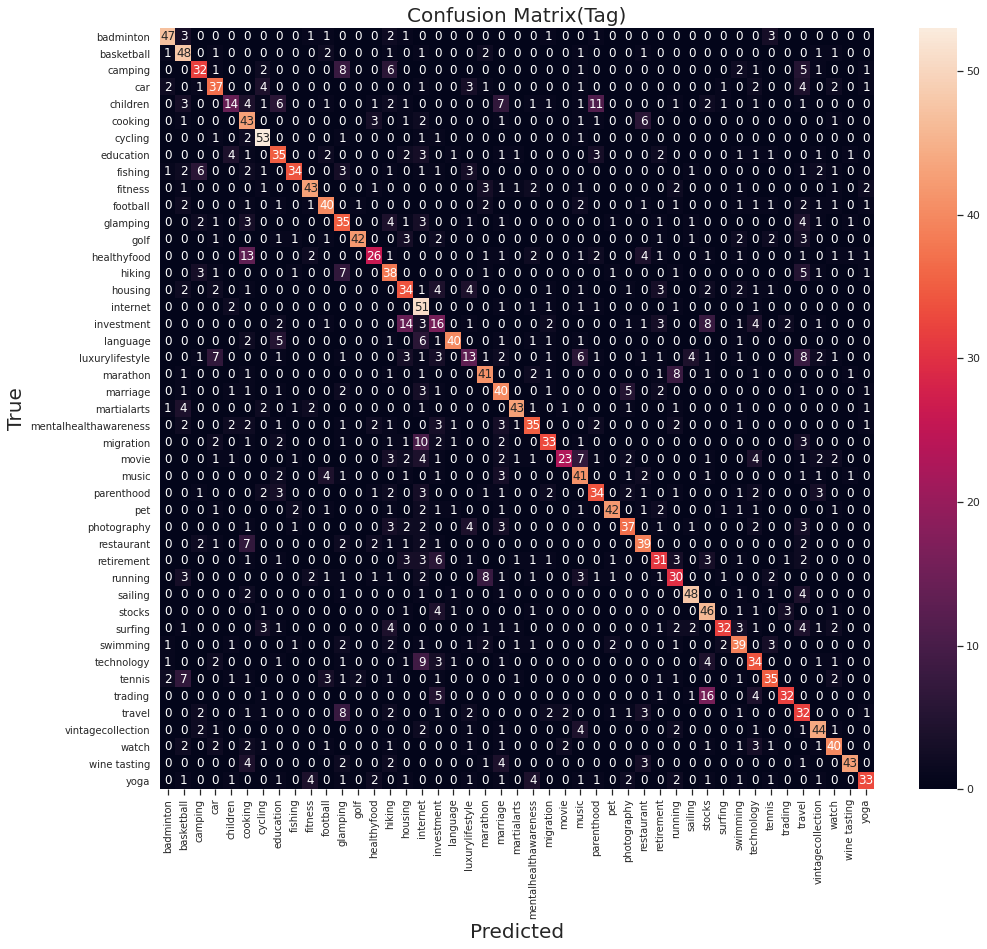

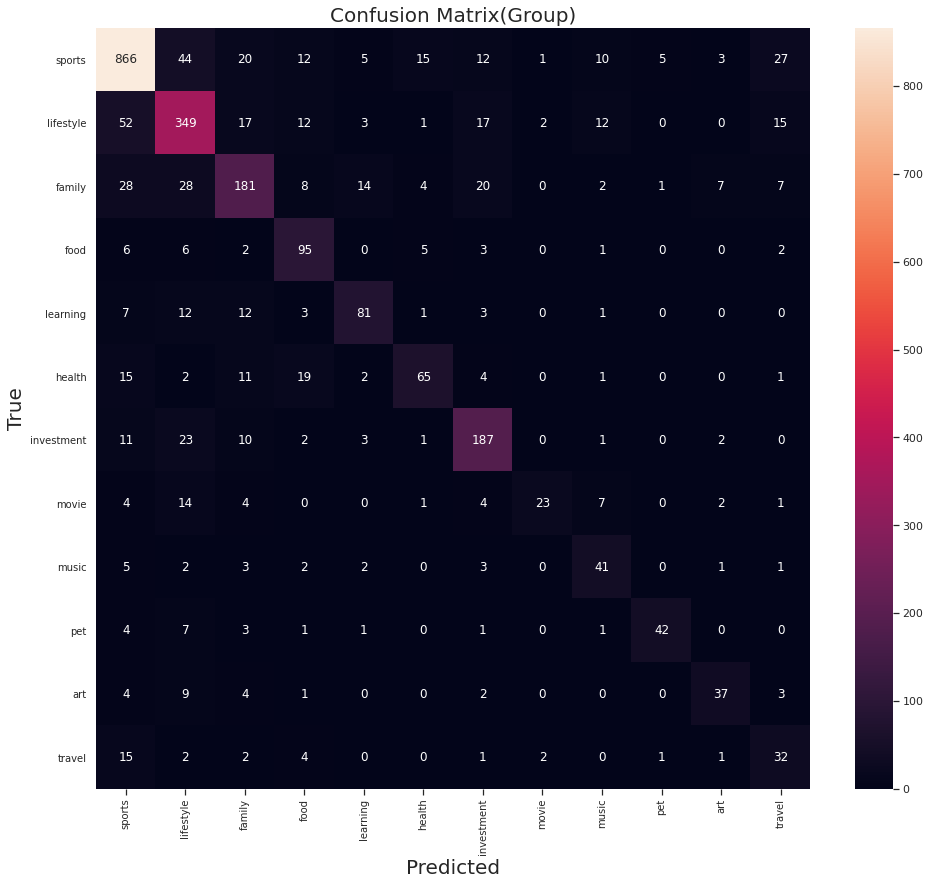

In [8]:
plot_confusion_matrix([index_to_tag['tag'][i] for i in y_random_pred], [index_to_tag['tag'][i] for i in y_true], index_to_tag['tag'].tolist(), title='Confusion Matrix(Tag)')
plot_confusion_matrix(y_random_pred_cat, y_true_cat, index_to_cat['cat'].tolist(), title='Confusion Matrix(Group)')

In [9]:
print_classification_report(y_random_pred, y_true, index_to_tag['tag'].tolist(), title='Classification Report (Tag):')
print_classification_report([cat_to_index.loc[i][0] for i in y_random_pred_cat], [cat_to_index.loc[i][0] for i in y_true_cat], index_to_cat['cat'].tolist(), title='Classification Report (Group):')

Classification Report (Tag):
                       precision    recall  f1-score   support

            badminton       0.84      0.78      0.81        60
           basketball       0.57      0.80      0.67        60
              camping       0.62      0.53      0.57        60
                  car       0.60      0.62      0.61        60
             children       0.52      0.23      0.32        60
              cooking       0.45      0.72      0.55        60
              cycling       0.73      0.88      0.80        60
            education       0.55      0.58      0.56        60
              fishing       0.81      0.57      0.67        60
              fitness       0.78      0.72      0.75        60
             football       0.69      0.67      0.68        60
             glamping       0.44      0.58      0.50        60
                 golf       0.93      0.70      0.80        60
          healthyfood       0.67      0.43      0.53        60
               hiking    

## 3.2 Bayesian Optimization

In [11]:
bayesian_time_start = time.time()

bayesian_param_grid = {
    'hidden_size': param_grid['hidden_size'],
    'dropout_rate': param_grid['dropout_rate'], 
    'learning_rate': param_grid['learning_rate'], 
    'l2_reg': param_grid['l2_reg'],
    'num_filters': param_grid['num_filters'],
    'pool_size': param_grid['pool_size'],
    'num_mlp_layers': param_grid['num_mlp_layers'],
    'num_cnn_layers': param_grid['num_cnn_layers'],
    'num_lstm_layers': param_grid['num_lstm_layers'],
    'kernel_index': param_grid['kernel_index'],
    'num_of_epochs': param_grid['num_of_epochs'],
    'sigmoid': param_grid['sigmoid']
}

# Bounded region of parameter space
optimizer = BayesianOptimization(
    f=train_bilstm_cnn,
    pbounds=bayesian_param_grid,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
#     random_state=random_seed
)

optimizer.maximize(init_points=50, n_iter=200)
bayesian_time_end = time.time()

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))
    
best_bay_params = optimizer.max['params']
bay_training_time = (bayesian_time_end - bayesian_time_start)/60


del bayesian_param_grid

|   iter    |  target   | dropou... | hidden... | kernel... |  l2_reg   | learni... | num_cn... | num_fi... | num_ls... | num_ml... | num_of... | pool_size |  sigmoid  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.0      |  0.2806   |  255.6    |  9.321    |  0.000630 |  0.008403 |  3.588    |  17.07    |  1.245    |  3.402    |  21.56    |  12.8     |  0.7515   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  2        |  0.02222  |  0.4401   |  37.26    |  3.731    |  0.000193 |  0.004793 |  1.866    |  61.46    |  4.189    |  4.541    |  23.0     |  16.91    |  0.5427   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  22       |  0.02222  |  0.1416   |  17.4     |  21.92    |  0.000686 |  0.005516 |  1.085    |  49.75    |  2.508    |  4.043    |  14.24    |  24.24    |  0.993    |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  23       |  0.02222  |  0.3519   |  47.83    |  8.31     |  0.000160 |  0.003073 |  2.178    |  15.01    |  1.709    |  1.725    |  16.13    |  35.31    |  0.4362   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  24       |  0.02222  |  0.1962   |  46.77    |  16.62    |  0.000990

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  44       |  0.02222  |  0.3937   |  193.2    |  22.63    |  0.000348 |  0.009633 |  1.657    |  63.6     |  1.563    |  3.92     |  21.74    |  15.76    |  0.8066   |
|  45       |  0.0      |  0.3665   |  152.3    |  19.96    |  0.000654 |  0.002379 |  4.612    |  41.87    |  2.459    |  4.061    |  19.09    |  36.3     |  0.869    |
|  46       |  0.0      |  0.312    |  65.96    |  30.96    |  0.00021  |  0.002006 |  3.463    |  12.29    |  3.946    |  2.421    |  13.54    |  58.56    |  0.221    |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  47       |  0.02222  |  0.3266   |  76.06    |  13.86    |  0.000495 |  0.007921 |  1.663    |  46.07    |  2.1      |  4.22     |  20.57    |  48.88  

EarlyStopping counter: 2 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  63       |  0.6007   |  0.1      |  196.9    |  9.122    |  0.0001   |  0.001    |  1.0      |  45.24    |  1.0      |  1.0      |  25.0     |  8.328    |  0.0      |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  64       |  0.5778   |  0.1      |  199.2    |  9.09     |  0.0001   |  0.001    |  1.0      |  45.91    |  1.0      |  1.0      |  25.0     |  8.214    |  0.0      |
|  65       |  0.0      |  0.436    |  189.8    |  5.774    |  0.000153 |  0.002174 |  4.06     |  40.25    |  3.913    |  3.986    |  23.33    |  8.264    |  0.9703   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping coun

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  83       |  0.03704  |  0.3402   |  201.0    |  1.615    |  0.000504 |  0.008078 |  1.501    |  44.02    |  1.764    |  1.56     |  23.06    |  9.773    |  0.4643   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  84       |  0.02222  |  0.3144   |  198.0    |  14.14    |  0.000497 |  0.001386 |  1.306    |  46.22    |  2.001    |  1.358    |  19.68    |  11.71    |  0.1631   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  85       |  0.02222  |  0.3242   |  194.5    |  10.93    |  0.000554 |  0.009869 |  1.932    |  44.21    |  4.269    |  2.691    |  22.28    |  13.59    |  0.9758   |
Ear

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  103      |  0.02222  |  0.3331   |  202.2    |  9.719    |  0.000785 |  0.001593 |  1.121    |  43.8     |  3.309    |  4.121    |  19.13    |  14.29    |  0.5771   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  104      |  0.4059   |  0.403    |  192.4    |  8.976    |  0.000257 |  0.004484 |  1.083    |  42.82    |  1.322    |  1.048    |  15.86    |  10.04    |  0.3468   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  105      |  0.02222  |  0.33     |

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  123      |  0.02222  |  0.3751   |  190.2    |  14.52    |  0.000862 |  0.006164 |  2.412    |  51.11    |  1.937    |  1.24     |  14.46    |  10.13    |  0.4868   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  124      |  0.02222  |  0.2889   |  192.1    |  9.193    |  0.000875 |  0.002517 |  2.667    |  46.93    |  3.495    |  3.505    |  17.44    |  8.905    |  0.1588   |
|  125      |  0.0      |  0.3771   |  220.6    |  26.82    |  0.000277 |  0.001431 |  4.969    |  2.567    |  3.498    |  1.978    |  6.037    |  8.578    |  0.672    |
EarlyStopping coun

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  142      |  0.02222  |  0.178    |  206.6    |  12.79    |  0.00036  |  0.008469 |  1.546    |  44.03    |  1.281    |  2.044    |  13.84    |  11.94    |  0.6135   |
|  143      |  0.0      |  0.2467   |  204.4    |  14.27    |  0.000176 |  0.009988 |  3.678    |  41.55    |  1.262    |  3.462    |  18.2     |  10.92    |  0.08515  |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  144      |  0.09778  |  0.3887   |  197.7    |  9.794    |  0.000774 |  0.004152 |  1.36     |  40.32    |  1.839    |  1.851    |  13.28    |  6.171    |  0.271    |
|  145      |  0.0      |  0.2207   |  205.2    |  10.57    |  0.000255 |  0.008091 | 

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  161      |  0.02222  |  0.1854   |  205.7    |  12.48    |  0.000643 |  0.006136 |  1.578    |  46.55    |  1.625    |  2.93     |  22.8     |  9.74     |  0.7426   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  162      |  0.02222  |  0.1674   |  208.1    |  10.25    |  0.000123 |  0.004736 |  1.98     |  45.83    |  3.057    |  4.704    |  19.48    |  11.89    |  0.302    |
|  163      |  0.0      |  0.4228   |  199.2    |  8.851    |  0.000492 |  0.004266 |  3.48     |  49.91    |  2.247    |  1.646    |  23.3     |  10.73    |  0.4851   |
|  164      |  0.0      |  0.4444   |  203.0    |  9.728    |  0.000949 |  0.005907 |  3.808    |  44.24    |  2.234    

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  181      |  0.02222  |  0.2835   |  199.8    |  9.993    |  0.000451 |  0.009466 |  1.57     |  50.27    |  3.387    |  1.965    |  12.4     |  3.461    |  0.2448   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  182      |  0.02222  |  0.2536   |  95.83    |  30.84    |  0.000322 |  0.001766 |  1.941    |  3.179    |  1.05     |  2.275    |  23.92    |  27.73    |  0.7844   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  183      |  0.02222  |  0.2191   |  39.44    |  28.41    |  0.000661 |  0.004528 |  3.87     |  33.05    |  1.516    |  2.331    |  24.7

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  200      |  0.02222  |  0.2767   |  200.0    |  6.406    |  0.000917 |  0.008364 |  1.008    |  49.26    |  3.777    |  2.803    |  19.15    |  4.944    |  0.4526   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 1 out of 4
|  201      |  0.02222  |  0.154    |  200.8    |  4.751    |  0.000869 |  0.001134 |  1.666    |  46.87    |  3.626    |  2.424    |  14.65    |  6.491    |  0.1486   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  202      |  0.02222  |  0.226    |  197.0    |  1

EarlyStopping counter: 4 out of 4
Early stopping
|  217      |  0.02222  |  0.3203   |  198.6    |  3.935    |  0.0001   |  0.00387  |  1.903    |  44.34    |  1.0      |  1.166    |  16.64    |  2.877    |  0.5649   |
|  218      |  0.0      |  0.2264   |  186.6    |  16.6     |  0.000720 |  0.009231 |  3.03     |  47.34    |  4.772    |  2.037    |  18.13    |  9.693    |  0.1405   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  219      |  0.02222  |  0.4034   |  190.1    |  7.949    |  0.000420 |  0.004567 |  1.195    |  45.0     |  3.614    |  3.389    |  15.58    |  6.358    |  0.1486   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  

EarlyStopping counter: 1 out of 4
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  237      |  0.02222  |  0.4396   |  199.8    |  2.942    |  0.000422 |  0.00431  |  3.329    |  42.93    |  4.914    |  1.069    |  10.66    |  3.378    |  0.7944   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  238      |  0.02222  |  0.3688   |  189.0    |  10.91    |  0.000852 |  0.003406 |  2.493    |  43.77    |  2.742    |  3.118    |  24.67    |  5.794    |  0.2518   |
EarlyStopping counter: 1 out of 4
EarlyStopping counter: 2 out of 4
EarlyStopping counter: 3 out of 4
EarlyStopping counter: 4 out of 4
Early stopping
|  239      |  0.02222  |  0.2144   |  191.6    |  14.5     |  0.000306 |  0.009764 |  2.765    |  47.58    |  1.356    |  4.878    |  19.08    |  4.612    |  0.5424   |
Ear

In [10]:
# best_bay_params = {'dropout_rate': 0.1,
#   'hidden_size': 196.85747900026632,
#   'kernel_index': 9.121572199128554,
#   'l2_reg': 0.0001,
#   'learning_rate': 0.001,
#   'num_cnn_layers': 1.0,
#   'num_filters': 45.23716716261858,
#   'num_lstm_layers': 1.0,
#   'num_mlp_layers': 1.0,
#   'num_of_epochs': 25.0,
#   'pool_size': 8.328123476806766,
#   'sigmoid': 0.0}
# bay_training_time = 745.5165005048116
best_bay_params, bay_training_time

({'dropout_rate': 0.1,
  'hidden_size': 196.85747900026632,
  'kernel_index': 9.121572199128554,
  'l2_reg': 0.0001,
  'learning_rate': 0.001,
  'num_cnn_layers': 1.0,
  'num_filters': 45.23716716261858,
  'num_lstm_layers': 1.0,
  'num_mlp_layers': 1.0,
  'num_of_epochs': 25.0,
  'pool_size': 8.328123476806766,
  'sigmoid': 0.0},
 745.5165005048116)

In [11]:
best_bay_model = load_model(f'best_bilstm_cnn_model_bay_{raw_data_size}')
y_true, y_bay_pred, y_true_cat, y_bay_pred_cat = predict(best_bay_model, test_loader, index_to_tag, tag_to_cat)

# Tag accuracy
best_bay_acc = accuracy_score(y_true, y_bay_pred)
# Cat accuracy
best_bay_cat_acc = accuracy_score(y_true_cat, y_bay_pred_cat)

best_bay_acc, best_bay_cat_acc, best_bay_params

100%|██████████| 169/169 [00:01<00:00, 138.17it/s]


(0.6007407407407407,
 0.7392592592592593,
 {'dropout_rate': 0.1,
  'hidden_size': 196.85747900026632,
  'kernel_index': 9.121572199128554,
  'l2_reg': 0.0001,
  'learning_rate': 0.001,
  'num_cnn_layers': 1.0,
  'num_filters': 45.23716716261858,
  'num_lstm_layers': 1.0,
  'num_mlp_layers': 1.0,
  'num_of_epochs': 25.0,
  'pool_size': 8.328123476806766,
  'sigmoid': 0.0})

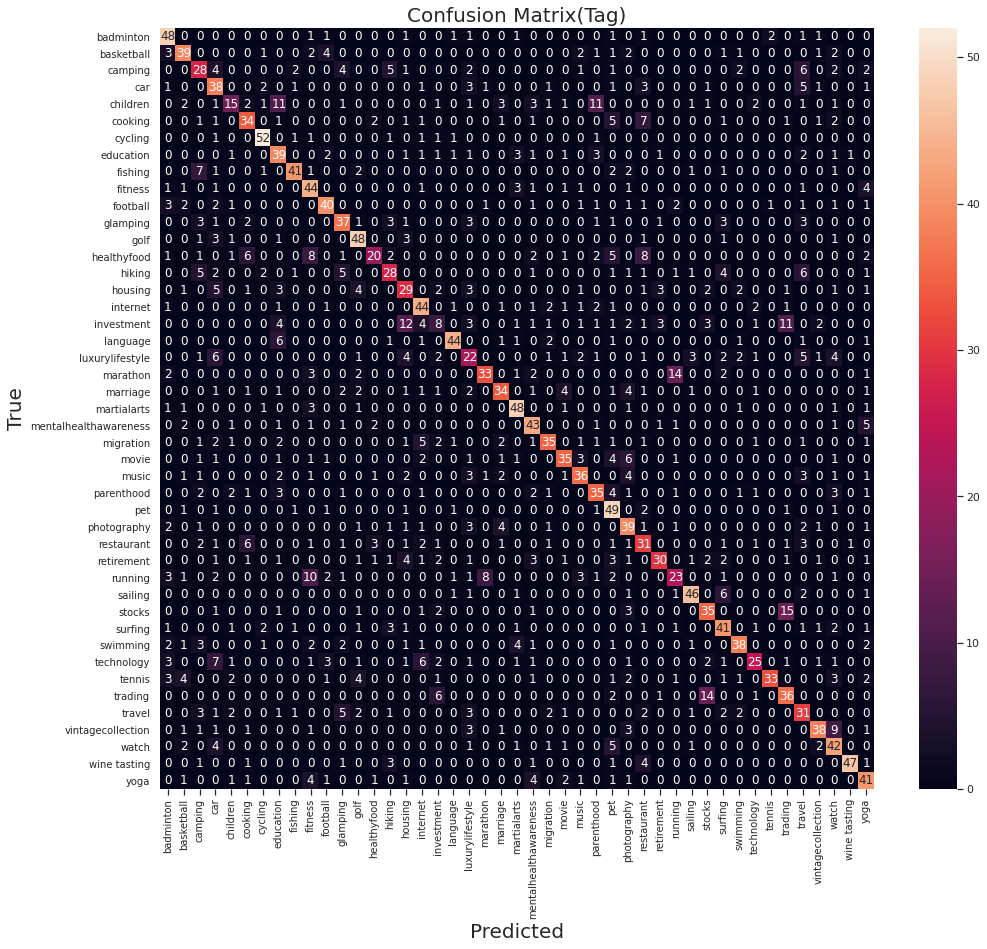

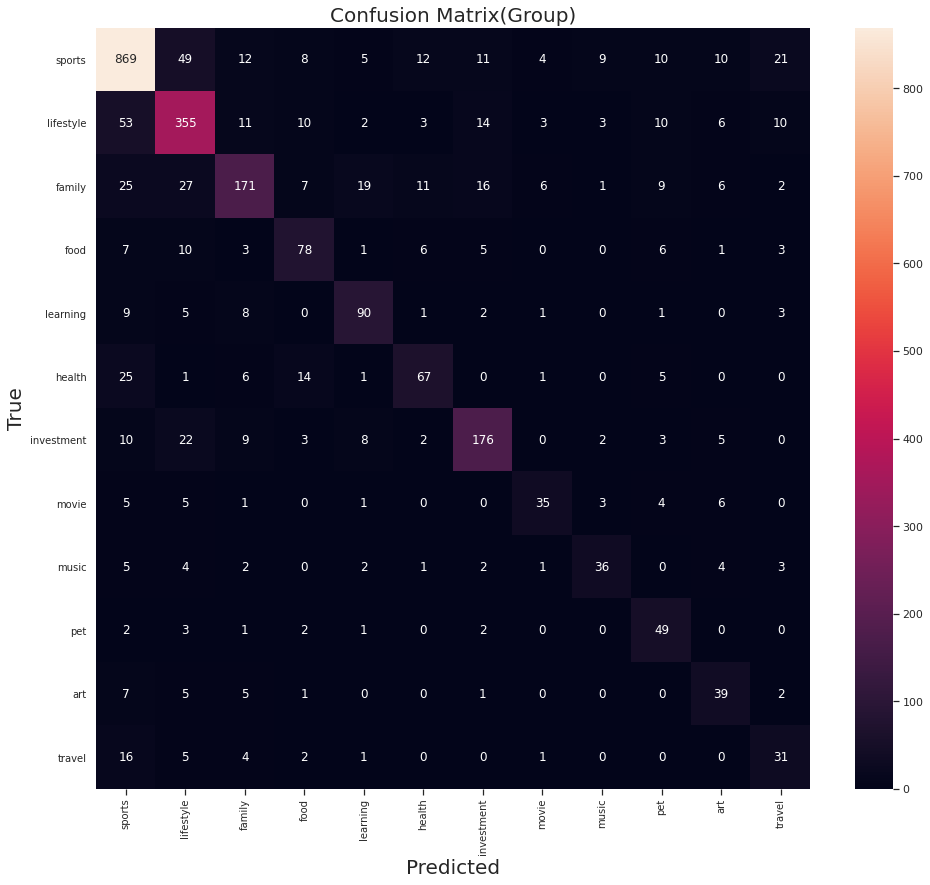

In [12]:
plot_confusion_matrix([index_to_tag['tag'][i] for i in y_bay_pred], [index_to_tag['tag'][i] for i in y_true], index_to_tag['tag'].tolist(), title='Confusion Matrix(Tag)')
plot_confusion_matrix(y_bay_pred_cat, y_true_cat, index_to_cat['cat'].tolist(), title='Confusion Matrix(Group)')

In [13]:
print_classification_report(y_bay_pred, y_true, index_to_tag['tag'].tolist(), title='Classification Report (Tag):')
print_classification_report([cat_to_index.loc[i][0] for i in y_bay_pred_cat], [cat_to_index.loc[i][0] for i in y_true_cat], index_to_cat['cat'].tolist(), title='Classification Report (Group):')

Classification Report (Tag):
                       precision    recall  f1-score   support

            badminton       0.64      0.80      0.71        60
           basketball       0.65      0.65      0.65        60
              camping       0.44      0.47      0.46        60
                  car       0.43      0.63      0.51        60
             children       0.50      0.25      0.33        60
              cooking       0.60      0.57      0.58        60
              cycling       0.83      0.87      0.85        60
            education       0.49      0.65      0.56        60
              fishing       0.84      0.68      0.75        60
              fitness       0.52      0.73      0.61        60
             football       0.70      0.67      0.68        60
             glamping       0.60      0.62      0.61        60
                 golf       0.67      0.80      0.73        60
          healthyfood       0.67      0.33      0.44        60
               hiking    

# 4. Result Summary

In [16]:
result = {
    'random_search': {
        'training_time(mins)': random_training_time,
        'accuracy': best_random_acc,
        'accuracy(group)': best_random_cat_acc,
        **get_clean_params(best_random_params)
    },
    'bayesian': {
        'training_time(mins)': bay_training_time,
        'accuracy': best_bay_acc,
        'accuracy(group)': best_bay_cat_acc,
        **get_clean_params(best_bay_params)
    },
}

In [17]:
result = pd.DataFrame.from_dict(result)
result

,random_search,bayesian
training_time(mins),990.017933,745.516501
accuracy,0.61037,0.600741
accuracy(group),0.74037,0.739259
hidden_size,256,196
dropout_rate,0.5,0.1
learning_rate,0.001,0.001
l2_reg,0.0001,0.0001
num_filters,64,45
pool_size,2,8
num_mlp_layers,1,1
